<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bibliotecas-e-Funções" data-toc-modified-id="Bibliotecas-e-Funções-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bibliotecas e Funções</a></span></li><li><span><a href="#Entendendo-os-Dados" data-toc-modified-id="Entendendo-os-Dados-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Entendendo os Dados</a></span><ul class="toc-item"><li><span><a href="#Dados-Nulos" data-toc-modified-id="Dados-Nulos-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Dados Nulos</a></span></li><li><span><a href="#Tipos-Primitivos" data-toc-modified-id="Tipos-Primitivos-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tipos Primitivos</a></span></li><li><span><a href="#Exploração-Gráfica" data-toc-modified-id="Exploração-Gráfica-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Exploração Gráfica</a></span><ul class="toc-item"><li><span><a href="#Evolução-do-E-Commerce-no-Brasil" data-toc-modified-id="Evolução-do-E-Commerce-no-Brasil-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Evolução do E-Commerce no Brasil</a></span></li><li><span><a href="#E-Commerce-nos-Estados-Brasileiros" data-toc-modified-id="E-Commerce-nos-Estados-Brasileiros-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>E-Commerce nos Estados Brasileiros</a></span></li><li><span><a href="#Formas-de-Pagamento-Online" data-toc-modified-id="Formas-de-Pagamento-Online-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Formas de Pagamento Online</a></span></li><li><span><a href="#Categorias-de-Produtos" data-toc-modified-id="Categorias-de-Produtos-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Categorias de Produtos</a></span></li><li><span><a href="#Review-Score" data-toc-modified-id="Review-Score-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Review Score</a></span></li></ul></li></ul></li><li><span><a href="#Processamento-de-Linguagem-Natural" data-toc-modified-id="Processamento-de-Linguagem-Natural-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Processamento de Linguagem Natural</a></span><ul class="toc-item"><li><span><a href="#Contato-Inicial-com-o-Dataset" data-toc-modified-id="Contato-Inicial-com-o-Dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Contato Inicial com o Dataset</a></span></li><li><span><a href="#RegEx" data-toc-modified-id="RegEx-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RegEx</a></span></li></ul></li></ul></div>

Este notebook tem por objetivo alocar o desenvolvimento prático envolvendo múltiplos conjuntos de dados contendo informações a respeito do E-Commerce do Brasil, dentro de um contexto relacionado ao trabalho final da matéria de Processamento de Linguagem Natural ministrada na UFABC pelo professor Jesús Mena.

Os dados públicos levantados pela empresa _Olist_ contemplam aproximadamente 100.000 registros de pediso on-line (e anônimos) dispostos em 8 diferentes datasets. Essa implementação visa realizar um estudo nos dados contidos nestes conjuntos com ênfase na aplicação de técnicas de PLN para análise e classificação de sentimentos de clientes coletados através das críticas postadas antes, durante ou após aquisições on-line.

Link do dataset: [Kaggle-Brazilian-e-commerce](https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_orders_dataset.csv)

# Bibliotecas e Funções

In [22]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import re
from nltk.stem import RSLPStemmer

In [19]:
# Funções
def format_spines(ax, right_border=True):
    """
    Função responsável por formatar os eixos dos gráficos
    
    Input:
        ax: matplotlib axis
        right_border: flag booleano que indica a presença ou não da borda direita
    
    Output:
        None
    """    
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    
def bar_plot(x, y, df, ax, colors='Blues_d', hue=False, value=False):
    """
    Função responsável por plotar, configurar e personalizar um gráfico de barras

    Input:
        x: feature a ser plotada no eixo x
        y: feature a ser plotada no eixo y
        df: dataframe utilizado
        colors: palette padrão "Blues_d"
        hue: feature de separação, padrão False
        value: flag que define se o rótulo das barras será valor (True) ou porcentagem (False)
        
    Returns:
        None
    """
    # Realizando contagem da feature numérica (em x ou em y)
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    
    # Plotando gráfico no eixo
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Configurando porcentagem ou valor
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom')
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom')
            
def add_series_working_days(series_name, df, date_col1, date_col2):
    """
    Função extremamente importante: calcula os dias úteis entre duas datas e retorna este valor
    como uma coluna adicional em um dataframe
    
    Input:
        series_names: nome da nova série criada para alocar a diferença em dias úteis
        df: conjunto de dados onde as colunas de data se encontram
        date_col1: coluna de datas 1
        date_col2: coluna de datas 2
        
    Returns:
        df_return: dataframe com coluna de dias úteis já inserida
    """
    # Calculando lista com diferença entre datas
    time_list = []
    idx = 0
    second_date_series = df[date_col2].values.astype('datetime64[D]')
    for date in df[date_col1].values.astype('datetime64[D]'):
        second_date = second_date_series[idx]
        try:
            workdays = np.busday_count(date, second_date)
        except:
            workdays = np.NaN
        time_list.append(workdays)
        idx += 1
    
    # Adicionando ao dataframe e eliminando valores nulos
    df_return = df.copy()
    df_return[series_name] = pd.Series(time_list)
    df_return.dropna(inplace=True)
    
    return df_return

def communicate_params(frete, entrega, estimativa):
    """
    Função adicional criada para auxiliar na plotagem gráfica do dashboard de análise por estado
    
    Input:
        frete: valor do frete a ser plotado no gráfico em formato de texto
        entrega: tempo médio de entrega a ser plotado no gráfico em formato de texto
        estimativa: diferença entre estimativa e entrega ser plotada no gráfico em formato de texto
    
    Returns:
        None
    """
    # Comunicando frete médio
    axs[0, 0].text(0.5, 0.12, str(f'Frete Médio \nR${frete:.2f}'),
                   fontsize=13, ha='center')
    axs[0, 0].axis('off')
    
    # Comunicando tempo médio de entrega
    axs[0, 1].text(0.5, 0.12, 
                   str(f'Tempo Médio de Entrega \n{int(entrega)} dias úteis.'),
                   fontsize=13, ha='center')
    axs[0, 1].axis('off')
    
    # Comunicando diferença entre tempo de entrega e tempo estimado
    if mean_diff_estimative > 0:
        inf = 'antes'
    else:
        inf = 'depois'
    text_diff_estimative = f'Em média, entregas \nacontecem {int(estimativa)} dias úteis \
\n{inf} do período estimado.'
    axs[0, 2].text(0.5, 0.10, 
                   str(text_diff_estimative), fontsize=13, ha='center')
    axs[0, 2].axis('off')
    
def plot_param(df, col, title, xlim, n_row, n_col, y='customer_state', div_xlim=0, 
               one_axis=False, xlabel=[], ylabel='Estado'):
    """
    Função utilizada para plotar um estudo comparativo de acordo com o tema, 
    separando análises de dos 5 Melhores e 5 Piores em assuntos pré-determinados
    
    Input:
        df: dataframe com as informações
        col: coluna com a informação a ser analisada
        title: título da análise
        xlim: limite no eixo X dos números
        n_row: índice da linha onde a plotagem será realizada
        n_col: índice da coluna onde a plotagem será realizada
    """
    # Configurando eixos
    if one_axis:
        ax_top = axs[n_col]
        ax_last = axs[n_col+1]
    else:
        ax_top = axs[n_row, n_col]
        ax_last = axs[n_row+1, n_col]
    
    # Primeiro passo: plotando Top 5
    df.sort_values(by=col, ascending=False, inplace=True)
    top5 = df.iloc[:5, :]
    sns.barplot(x=col, y=y, data=top5, ci=None, palette='Blues_d', ax=ax_top)
    format_spines(ax_top, right_border=False)
    ax_top.set_title(title)
    ax_top.set_xlim(0, xlim)
    ax_top.set_xlabel(xlabel)
    if n_col > 0:
        ax_top.set_ylabel('')
    else:
        ax_top.set_ylabel(ylabel)
    
    # Segundo passo: plotando Top 5 inverso
    last5 = df.iloc[-5:, :]
    sns.barplot(x=col, y=y, data=last5, ci=None, palette='Blues_d', ax=ax_last)
    format_spines(ax_last, right_border=False)
    ax_last.set_title(title.replace('Maior', 'Menor'))
    if div_xlim > 0:
        ax_last.set_xlim(0, xlim/div_xlim)
    else:
        ax_last.set_xlim(0, xlim)
    ax_last.set_xlabel(xlabel)
    if n_col > 0:
        ax_last.set_ylabel('')
    else:
        ax_last.set_ylabel(ylabel)
        
def donut_plot(col, ax, df, labels, text='', flag_ruido = 0,
               colors=['navy', 'lightsteelblue', 'lightgreen', 'crimson', '']):
    """
    Função responsável por plotar um gráfico de rosca customizado
    
    Input:
        col: coluna a ser analisada e plotada no gráfico de rosca
        ax: matplotlib axis
        df: DataFrame contendo os dados
        labels: índice de labels da coluna a ser plotada
        text: texto a ser plotado no centro do gráfico de rosca
        flag_ruido: indica a quantidade de elementos a serem eliminados da plotagem
        colors: lista de cores para plotagem (4 cores default)
    """
    flag_ruido = flag_ruido * -1
    if flag_ruido < 0:
        sizes = df[col].value_counts().values[:flag_ruido]
        labels = labels[:flag_ruido]
    else:
        sizes = df[col].value_counts().values
    center_circle = plt.Circle((0,0), 0.80, color='white')
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%')
    ax.add_artist(center_circle)
    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    
def stem_processing(c):
    """
    Função responsável por realizar o stemming nas críticas.
    
    Input:
        c: crítica do cliente
    
    Output:
        critica aplicado stemming
    """
    
    stemmer = PorterStemmer()
    print([word for word in c.split()])
    return list(map(lambda x: stemmer.stem(x),[word for word in c.split()]))

In [21]:
stem_processing("estudarei estudar gato importando gatinha")

['estudarei', 'estudar', 'gato', 'importando', 'gatinha']


['estudarei', 'estudar', 'gato', 'importando', 'gatinha']

# Entendendo os Dados

Datasets disponíveis:

    olist_customers_dataset.csv
    olist_geolocation_dataset.csv
    olist_orders_dataset.csv
    olist_order_items_dataset.csv
    olist_order_payments_dataset.csv
    olist_order_reviews_dataset.csv
    olist_products_dataset.csv
    olist_sellers_dataset.csv
    product_category_name_translation.csv

<img src="images/brazilian_e-commerce_schema.png" alt="Dataset Schema" style="width: 750px;"/>

Acima, é possível visualizar um modelo que transcreve o problema de negócio. A relação entre os datasets é dada através de chaves estrangeiras contidas em cada um dos conjuntos, sendo necessária a aplicação de métodos específicos (join, concat, entre outros) para a efetiva união e posterior análise dos conjuntos. Neste primeiro momento, vamos ler os conjuntos de dados e verificar as dimensões de cada um deles.

In [3]:
# Lendo arquivos
olist_customer = pd.read_csv('olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('olist_products_dataset.csv')
olist_sellers = pd.read_csv('olist_sellers_dataset.csv')

In [4]:
# Exemplo: dataset de pedidos
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
# Visualizando colunas em cada um dos conjuntos
dataframes = {
    'Customers': olist_customer,
    'Geolocation': olist_geolocation,
    'Orders': olist_orders,
    'Items': olist_order_items,
    'Payments': olist_order_payments,
    'Reviews': olist_order_reviews,
    'Products': olist_products,
    'Sellers': olist_sellers
}

for name, df in dataframes.items():
    print(f'{name}: {len(df.columns)} colunas')
    print(f'{list(df.columns)}\n')

Customers: 5 colunas
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Geolocation: 5 colunas
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

Orders: 8 colunas
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Items: 7 colunas
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments: 5 colunas
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Reviews: 7 colunas
['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

Products: 9 colunas
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty

In [6]:
# Chaves estrangeiras
for name, df in dataframes.items():
    chaves = [col for col in df.columns if '_id' in col or 'code' in col]
    print(f'{name}: {len(chaves)} chaves PK ou FK')
    print(f'{chaves}\n')

Customers: 3 chaves PK ou FK
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix']

Geolocation: 1 chaves PK ou FK
['geolocation_zip_code_prefix']

Orders: 2 chaves PK ou FK
['order_id', 'customer_id']

Items: 4 chaves PK ou FK
['order_id', 'order_item_id', 'product_id', 'seller_id']

Payments: 1 chaves PK ou FK
['order_id']

Reviews: 2 chaves PK ou FK
['review_id', 'order_id']

Products: 1 chaves PK ou FK
['product_id']

Sellers: 2 chaves PK ou FK
['seller_id', 'seller_zip_code_prefix']



## Dados Nulos

Vamos verificar a presença de dados nulos em uma visão macro, considerando os datasets como um todo

In [7]:
# Em quais datasets existem dados nulos?
for name, df in dataframes.items():
    print(f'{name:<11} - {df.isnull().any().any()}')

Customers   - False
Geolocation - False
Orders      - True
Items       - False
Payments    - False
Reviews     - True
Products    - True
Sellers     - False


Vamos agora quantificar os dados nulos em todos os conjuntos

In [8]:
# Quantificando dados nulos
for name, df in dataframes.items():
    if df.isnull().any().any():
        print(f'Dataset: {name}\n')
        print(f'{df.isnull().sum()}\n')

Dataset: Orders

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Dataset: Reviews

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Dataset: Products

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64



* Os dados nulos no dataset **Orders** são dados por:

    - Pedidos sem data de aprovação;
    - Pedidos que não foram entregues na transportadora;
    - Pedidos ainda não entregues aos clientes.


* Os dados nulos no dataset **Reviews** são dados por:
    - Pedidos sem comentários;
    - Comentários postados sem título;


* Os dados nulos no dataset **Produtos** são dados por:
    - Produtos sem categoria, sem informações de nome, descrição, fotos e atributos

## Tipos Primitivos

Ainda trabalhando nos passos precedentes a análise exploratória e posterior implementação das técnicas de PLN para classificação de sentimentos, é preciso verificar os tipos primitivos dos dados para aplicar as transformações que se fizerem necessárias

In [9]:
# Verificando tipos primitivos
for name, df in dataframes.items():
    print(f'Dataset: {name}\n')
    print(f'{df.dtypes}\n')

Dataset: Customers

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Dataset: Geolocation

geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

Dataset: Orders

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Dataset: Items

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
frei

As colunas a seguir devem ser transformadas para o tipo *datetime*:

    order_purchase_timestamp
    order_approved_at
    order_delivered_carrier_date
    order_delivered_customer_date
    order_estimated_delivery_date

In [10]:
# Aplicando transformações
time_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in time_cols:
    olist_orders[col] = pd.to_datetime(olist_orders[col])
    
# Verificando
olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

## Exploração Gráfica

Para que possa ser criado um melhor relacionamento com os dados, objetivando o ganho de insights a respeito do comportamento de clientes que realizam compras on-line, serão propostas análises gráficas. Esta sessão é de extrema importância para que, ao serem aplicadas técnicas de PLN para identificar o sentimento de clientes a partir de comentários e críticas postadas antes, durante ou após as compras, seja captada a ideia final de uma forma mais ampla, auxiliando assim no entendimento dos resultados obtidos.

### Evolução do E-Commerce no Brasil

Sabe-se que a realização de compras online é uma modalidade que cresce cada dia mais ao redor do mundo. No Brasil, isso não é diferente. Há poucos anos atrás, o receio e a sensação de insegurança eram os principais termos que relacionavam aquisições via e-commerce. Hoje, muitos preferem associar a comodidade e a facilidade para descrever essa modalidade de compra.

Os dados propostos refletem essa análise?

In [11]:
# Criando nova coluna para ano
olist_orders['order_purchase_year'] = \
olist_orders['order_purchase_timestamp'].apply(lambda x: x.year)

# Criando nova coluna para mês
olist_orders['order_purchase_month'] = \
olist_orders['order_purchase_timestamp'].apply(lambda x: x.month)

# Criando nova coluna para dia da semana
olist_orders['order_purchase_dayofweek'] = \
olist_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)

* **Quantidade de Pedidos por Ano**

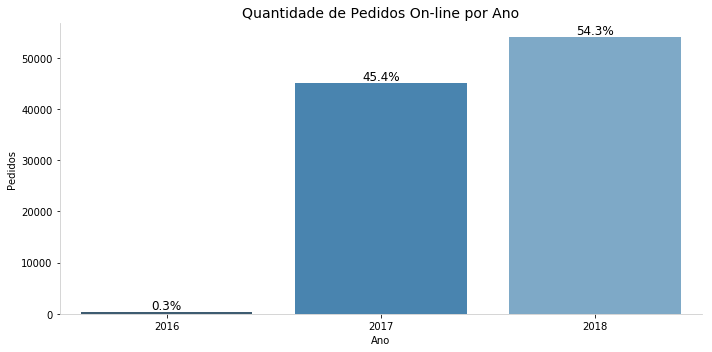

In [12]:
# Preparando plotagem
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year', data=olist_orders, palette='Blues_d')
format_spines(ax, right_border=False)

# Mostrando frequência
ncount = len(olist_orders)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', size=12)

ax.set_title('Quantidade de Pedidos On-line por Ano', size=14)
ax.set_ylabel('Pedidos')
ax.set_xlabel('Ano')

plt.tight_layout()
plt.show()

Realmente é possível notar um crescimento na quantidade de compras online feitas entre 2017 e 2018. Entretanto, é preciso ter cuidado com o valor extremamente baixo relacionado ao ano de 2016. É possível que o conjunto de dados não contemple a totalidade deste ano.

In [13]:
# Range das amostras
print(f'Data mínima presente: {olist_orders["order_purchase_timestamp"].min()}')
print(f'Data máxima presente: {olist_orders["order_purchase_timestamp"].max()}')

Data mínima presente: 2016-09-04 21:15:19
Data máxima presente: 2018-10-17 17:30:18


* **Total de Vendas ao Longo do Tempo**

In [14]:
# Unindo datasets de pedidos e itens
df_orders_items = olist_orders.merge(olist_order_items, on='order_id', how='inner')

# Criando uma coluna para somar o valor do item + frete
df_orders_items['total_sales'] = df_orders_items['price'] + df_orders_items['freight_value']

# Agrupando datasets por vendas mensais e anuais
df_sales = df_orders_items.groupby(['order_purchase_year', 'order_purchase_month'], 
                         as_index=False).sum()
df_sales = df_sales.loc[:, ['order_purchase_year', 'order_purchase_month', 'total_sales']]

# Separando conjuntos por ano
df_sales_2016 = df_sales[df_sales['order_purchase_year']==2016]
df_sales_2017 = df_sales[df_sales['order_purchase_year']==2017]
df_sales_2018 = df_sales[df_sales['order_purchase_year']==2018]

In [15]:
# Preenchendo meses não presentes nos datasets
months = np.arange(1, 13)
df_append = pd.DataFrame({})
grouped_dfs = df_sales_2016, df_sales_2017, df_sales_2018
years = [2016, 2017, 2018]
idx = 0

# Laço para preenchimento dos dados
for df in grouped_dfs:
    for month in months:
        # Se existe um mês não presente no dataset
        if month not in df['order_purchase_month'].values:
            dict_append = {
                'order_purchase_year': years[idx],
                'order_purchase_month': month,
                'total_sales': 0
            }
            df_append = df_append.append(dict_append, ignore_index=True)
    # Insere o dicionário no dataset e ordena
    df = df.append(df_append).astype(int)
    df.sort_values(by='order_purchase_month', inplace=True)
    df_append = pd.DataFrame({})
    # Atribui os resultados aos respectivos conjuntos
    if idx == 0:
        df_sales_2016 = df
    elif idx == 1:
        df_sales_2017 = df
    else:
        df_sales_2018 = df
    idx += 1

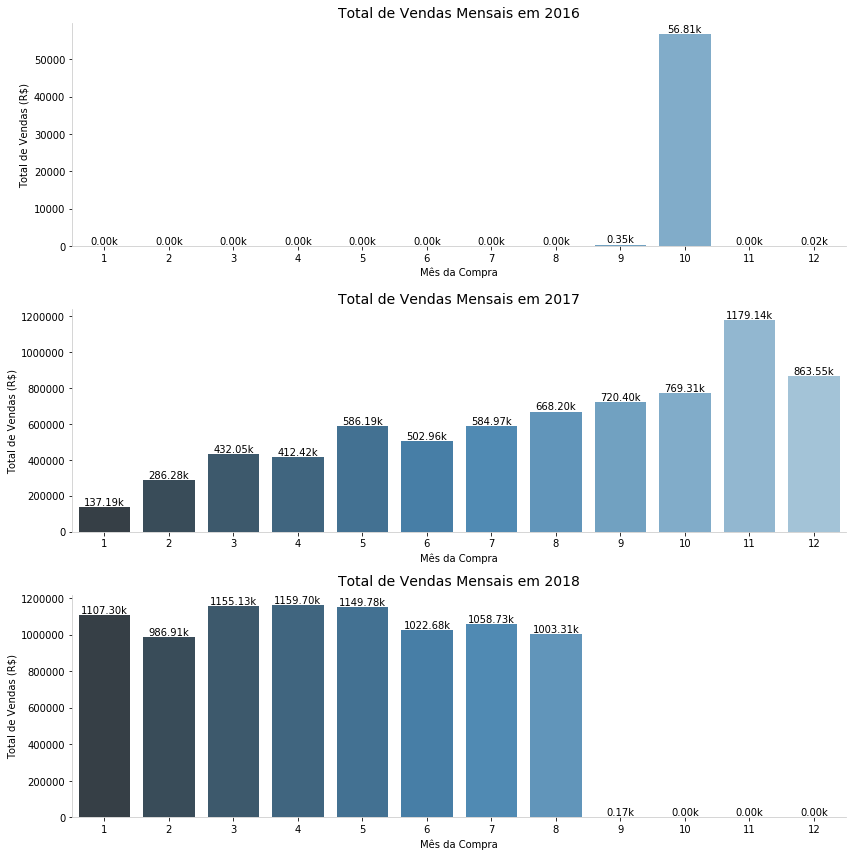

In [16]:
# Quantidade de vendas online por mês (neste dataset)
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
bar_plot(x='order_purchase_month', y='total_sales', df=df_sales_2016, ax=axs[0], value=True)
bar_plot(x='order_purchase_month', y='total_sales', df=df_sales_2017, ax=axs[1], value=True)
bar_plot(x='order_purchase_month', y='total_sales', df=df_sales_2018, ax=axs[2], value=True)

# Formatando
axs_list = axs[0], axs[1], axs[2]
for ax in axs_list:
    format_spines(ax, right_border=False)
    ax.set_xlabel('Mês da Compra')
    ax.set_ylabel('Total de Vendas (R$)')
axs[0].set_title('Total de Vendas Mensais em 2016', size=14)
axs[1].set_title('Total de Vendas Mensais em 2017', size=14)
axs[2].set_title('Total de Vendas Mensais em 2018', size=14, pad=10)
plt.tight_layout()
plt.show()

* **Evolução de Vendas em uma Linha do Tempo**

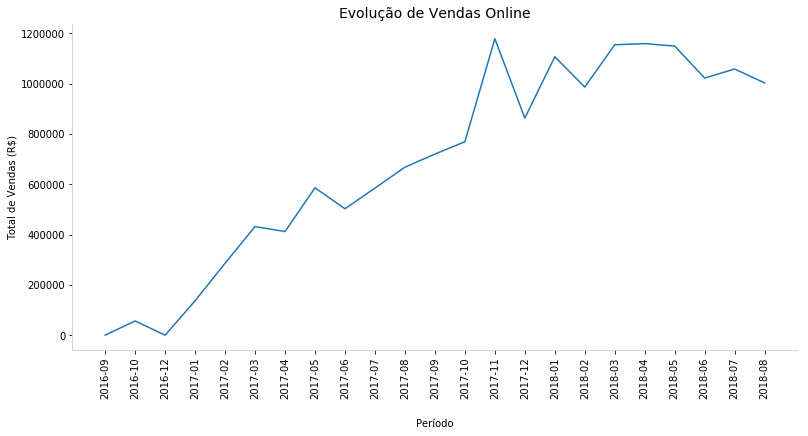

In [17]:
# Transformando coluna mês para correta ordenação na plotagem
df_sales['order_purchase_month'] = df_sales['order_purchase_month'].astype(str).\
apply(lambda x: '0' + x if len(x) == 1 else x)

# Criando nova coluna com ano-mês
df_sales['month_year'] = df_sales['order_purchase_year'].astype(str) + '-' + \
df_sales['order_purchase_month'].astype(str)

# Retornando o tipo primitivo da coluna mês
df_sales['order_purchase_month'] = df_sales['order_purchase_month'].astype(int)

# Plotando dados
fig, ax = plt.subplots(figsize=(13, 6))
ax = sns.lineplot(x='month_year', y='total_sales', data=df_sales.iloc[:-1, :])
format_spines(ax, right_border=False)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('Período', labelpad=20)
ax.set_ylabel('Total de Vendas (R$)')
ax.set_title('Evolução de Vendas Online', size=14)
plt.show()

* **Evolução de Vendas nos Últimos Dois Anos**

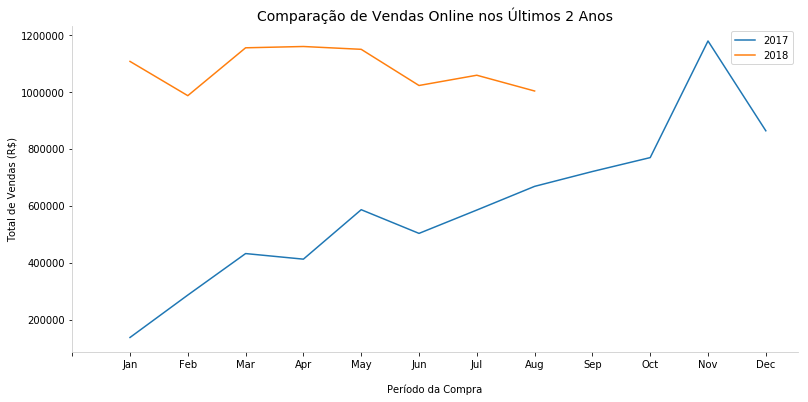

In [18]:
# Cruzando dados de 2017 e 2018
fig, ax = plt.subplots(figsize=(13, 6))
ax = sns.lineplot(x='order_purchase_month', y='total_sales', data=df_sales_2017, label='2017')
ax = sns.lineplot(x='order_purchase_month', y='total_sales', 
                  data=df_sales_2018.iloc[:-4, :], label='2018')
format_spines(ax, right_border=False)
ax.set_xlabel('Período da Compra', labelpad=15)
ax.set_ylabel('Total de Vendas (R$)')
ax.set_title('Comparação de Vendas Online nos Últimos 2 Anos', size=14)
plt.xticks(np.arange(13), ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
                           'Oct', 'Nov', 'Dec'])
plt.show()

* **Média de Vendas por Dia da Semana**

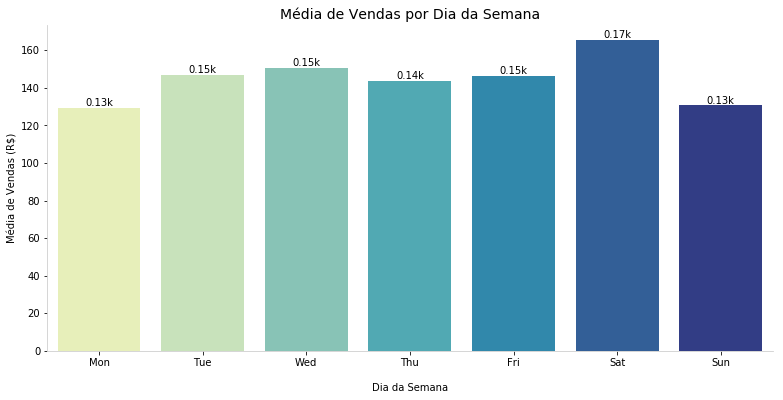

In [19]:
# Média de vendas por dia da semana
df_sales_dow_mean = \
df_orders_items.groupby(['order_purchase_year', 'order_purchase_dayofweek'], 
                        as_index=False).mean().iloc[:, np.c_[0, 1, 6][0]]

# Plotando gráfico
fig, ax = plt.subplots(figsize=(13, 6))
bar_plot(x='order_purchase_dayofweek', y='total_sales', ax=ax,
         df=df_sales_dow_mean, colors='YlGnBu', value=True)
ax.set_xlabel('Dia da Semana', labelpad=15)
ax.set_ylabel('Média de Vendas (R$)')
ax.set_title('Média de Vendas por Dia da Semana', size=14)
format_spines(ax, right_border=False)
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

### E-Commerce nos Estados Brasileiros

Após entender um pouco mais sobre como o e-commerce no Brasil vem evoluindo e como isso se transmite a partir do conjunto de dados utilizado, será proposta uma análise que leva em consideração a atuação do comércio online em cada um dos estados brasileiros.

* **Total de Vendas Online por Estado**

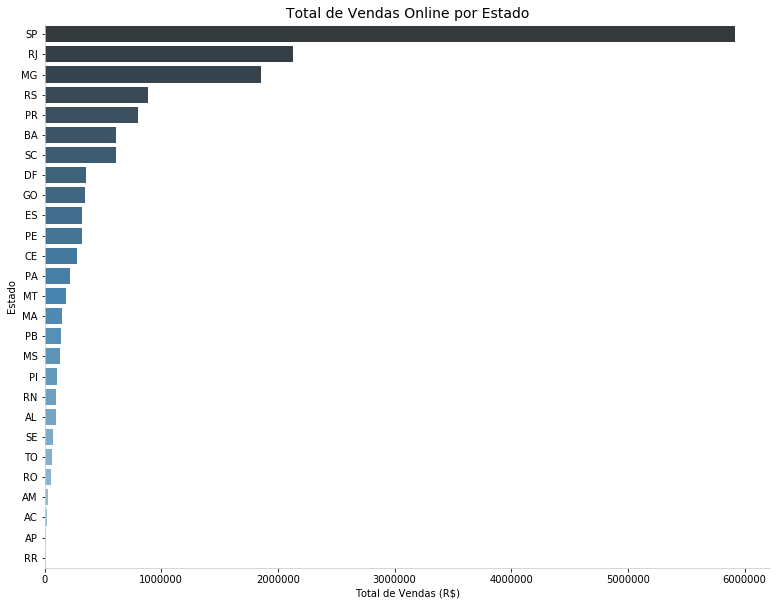

In [20]:
# Unindo dataset de clientes
df_sales_customer = df_orders_items.merge(olist_customer, on='customer_id', how='inner')

# Agrupando total de vendas por estado
df_sales_state = df_sales_customer.groupby(['customer_state'], 
                                          as_index=False).sum().iloc[:, np.c_[(0, -2, -3)][0]]
df_sales_state.sort_values(by='total_sales', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(13, 10))
sns.barplot(x='total_sales', y='customer_state', data=df_sales_state, ci=None,
                 palette='Blues_d')
format_spines(ax, right_border=False)
ax.set_title('Total de Vendas Online por Estado', size=14)
ax.set_xlabel('Total de Vendas (R$)')
ax.set_ylabel('Estado')
plt.show()

Para a próxima plotagem gráfica, serão realizados alguns preparativos nos dados com o objetivo de criar uma visão geral sobre os Estados considerando:
* **Valor do frete**
* **Tempo médio de entrega**
* **Diferença entre data estimativa e data de entrega**

In [21]:
# Calculando dias úteis de entrega
df_delivery_time = add_series_working_days(series_name='time_to_delivery', 
                                           df=df_sales_customer,
                                           date_col1 = 'order_purchase_timestamp', 
                                           date_col2 = 'order_delivered_customer_date')

# Agrupando tempo médio de entrega por estado
df_delivery_time = df_delivery_time.groupby(['customer_state'], as_index=False).mean()
df_delivery_time = df_delivery_time.iloc[:, np.c_[(0, -1)][0]]

# Calculando dias úteis entre a data de entrega e a data estimada
df_diff_est_deliv = add_series_working_days(series_name='diff_est_deliv', 
                                           df=df_sales_customer,
                                           date_col1 = 'order_delivered_customer_date', 
                                           date_col2 = 'order_estimated_delivery_date')

# Agrupando tempo médio de entrega por estado
df_diff_est_deliv = df_diff_est_deliv.groupby(['customer_state'], as_index=False).mean()
df_diff_est_deliv = df_diff_est_deliv.iloc[:, np.c_[(0, -1)][0]]
df_diff_est_deliv['diff_est_deliv'] = df_diff_est_deliv['diff_est_deliv'].astype(int)

# Calculando parâmetros informativos
df_mean_freight = df_sales_customer.groupby(['customer_state'], 
                                as_index=False).mean().iloc[:, np.c_[(0, -2, -3)][0]]
mean_freight_value = df_mean_freight['freight_value'].mean()
mean_delivery_time = df_delivery_time['time_to_delivery'].mean()
mean_diff_estimative = df_diff_est_deliv['diff_est_deliv'].mean()

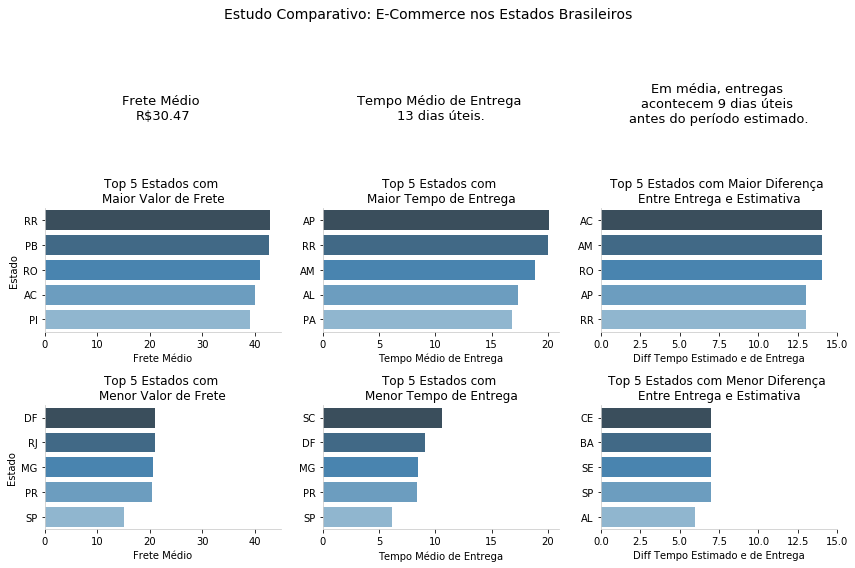

In [22]:
# Plotando
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
communicate_params(mean_freight_value, mean_delivery_time, mean_diff_estimative)

# Plotando informações de frete
plot_param(df=df_mean_freight, col='freight_value', 
           title='Top 5 Estados com \nMaior Valor de Frete', xlim=45, n_row=1, n_col=0, xlabel='Frete Médio')

# Plotando informações sobre tempo de entrega
plot_param(df=df_delivery_time, col='time_to_delivery', 
           title='Top 5 Estados com \nMaior Tempo de Entrega', xlim=21, n_row=1, n_col=1, 
           xlabel='Tempo Médio de Entrega')

# Plotando informações sobre diferença entre data de entrega e data estimada
plot_param(df=df_diff_est_deliv, col='diff_est_deliv', 
           title='Top 5 Estados com Maior Diferença \nEntre Entrega e Estimativa', 
           xlim=15, n_row=1, n_col=2, xlabel='Diff Tempo Estimado e de Entrega')

plt.suptitle('Estudo Comparativo: E-Commerce nos Estados Brasileiros', size=14)
plt.tight_layout()
plt.show()

### Formas de Pagamento Online

Neste tópico, serão estudados as formas de pagamento mais comuns encontrada em transações online.

* **Frequência de Métodos de Pagamento**

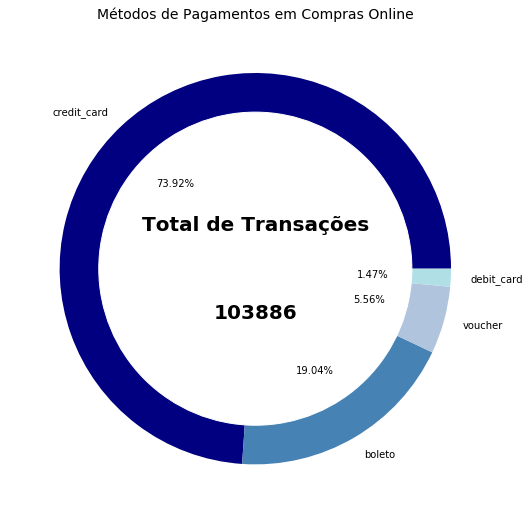

In [25]:
payments_labels = olist_order_payments['payment_type'].value_counts().index
total_transacoes = len(olist_order_payments)
text = f'Total de Transações\n\n\n\n{total_transacoes}'
colors = ['navy', 'steelblue', 'lightsteelblue', 'powderblue']#, 'lightcyan']
fig, ax = plt.subplots(figsize=(9, 9))
donut_plot('payment_type', ax, olist_order_payments, labels=payments_labels, text=text, 
           colors=colors, flag_ruido=1)
ax.set_title('Métodos de Pagamentos em Compras Online', size=14)

plt.show()

* **Evolução de Meios de Pagamento ao Longo do Tempo**

In [26]:
df_orders_payments = olist_orders.merge(olist_order_payments, on='order_id', how='left')
payments_evolution = df_orders_payments.groupby(by=['order_purchase_year', 'order_purchase_month',
                                                    'payment_type'], as_index=False).count().iloc[:, :4]

payments_evolution = payments_evolution.query('payment_type != "not_defined"')

In [27]:
"""
payments_evolution_2016 = payments_evolution[payments_evolution['order_purchase_year']==2016]
payments_evolution_2017 = payments_evolution[payments_evolution['order_purchase_year']==2017]
payments_evolution_2018 = payments_evolution[payments_evolution['order_purchase_year']==2018]

months = np.arange(1, 13)
metodos = ['boleto', 'credit_card', 'debit_card', 'voucher']
df_append_boleto = pd.DataFrame({})
df_append_cc = pd.DataFrame({})
df_append_debito = pd.DataFrame({})
df_append_voucher = pd.DataFrame({})
df_append_metodo = pd.DataFrame({})
grouped_payments = payments_evolution_2016, payments_evolution_2017, payments_evolution_2018
years = [2016, 2017, 2018]
idx = 0

for df in grouped_payments:
    for month in months:
        # Se existe um mês não presente no dataset
        if month not in df['order_purchase_month'].values:
            
            # Adiciona resultados de boleto para meses faltantes
            dict_append_boleto = {
                'order_purchase_year': years[idx],
                'order_purchase_month': month,
                'payment_type': 'boleto',
                'order_id': 0
            }
            df_append_boleto = df_append_boleto.append(dict_append_boleto, ignore_index=True)
            
            # Adiciona resultados de credit card para meses faltantes
            dict_append_cc = {
                'order_purchase_year': years[idx],
                'order_purchase_month': month,
                'payment_type': 'credit_card',
                'order_id': 0
            }
            df_append_cc = df_append_cc.append(dict_append_cc, ignore_index=True)
            
            # Adiciona resultados de debit card para meses faltantes
            dict_append_debito = {
                'order_purchase_year': years[idx],
                'order_purchase_month': month,
                'payment_type': 'debit_card',
                'order_id': 0
            }
            df_append_debito = df_append_debito.append(dict_append_debito, ignore_index=True)
            
            # Adiciona resultados de voucher para meses faltantes
            dict_append_voucher = {
                'order_purchase_year': years[idx],
                'order_purchase_month': month,
                'payment_type': 'voucher',
                'order_id': 0
            }
            df_append_voucher = df_append_voucher.append(dict_append_voucher, ignore_index=True)
    
    # Insere o dicionário no dataset
    df = df.append(df_append_boleto)
    df = df.append(df_append_cc)
    df = df.append(df_append_debito)
    df = df.append(df_append_voucher)
      
    # Se não existe um método de pagamento em um mês         
    for imonth in months:
        for metodo in metodos:
            if metodo not in df.query('order_purchase_month == @imonth')['payment_type'].values:
                dict_append_metodo = {
                        'order_purchase_year': years[idx],
                        'order_purchase_month': imonth,
                        'payment_type': metodo,
                        'order_id': 0
                    }
                df_append_metodo = df_append_metodo.append(dict_append_metodo, ignore_index=True)
    
    df = df.append(df_append_metodo)
    # Ordena valores por mês e reinicia variáveis
    df.sort_values(by='order_purchase_month', inplace=True)
    df_append_boleto = pd.DataFrame({})
    df_append_cc = pd.DataFrame({})
    df_append_debito = pd.DataFrame({})
    df_append_metodo = pd.DataFrame({})
    
    # Atribui os resultados aos respectivos conjuntos
    if idx == 0:
        payments_evolution_2016 = df
    elif idx == 1:
        payments_evolution_2017 = df
    else:
        payments_evolution_2018 = df
    idx += 1
    
payments_evolution_2017 = payments_evolution_2017.query('order_purchase_year == 2017')
payments_evolution_2018 = payments_evolution_2018.query('order_purchase_year == 2018')
payments_evolution_2018 = payments_evolution_2018.query('payment_type != "not_defined"')"""

'\npayments_evolution_2016 = payments_evolution[payments_evolution[\'order_purchase_year\']==2016]\npayments_evolution_2017 = payments_evolution[payments_evolution[\'order_purchase_year\']==2017]\npayments_evolution_2018 = payments_evolution[payments_evolution[\'order_purchase_year\']==2018]\n\nmonths = np.arange(1, 13)\nmetodos = [\'boleto\', \'credit_card\', \'debit_card\', \'voucher\']\ndf_append_boleto = pd.DataFrame({})\ndf_append_cc = pd.DataFrame({})\ndf_append_debito = pd.DataFrame({})\ndf_append_voucher = pd.DataFrame({})\ndf_append_metodo = pd.DataFrame({})\ngrouped_payments = payments_evolution_2016, payments_evolution_2017, payments_evolution_2018\nyears = [2016, 2017, 2018]\nidx = 0\n\nfor df in grouped_payments:\n    for month in months:\n        # Se existe um mês não presente no dataset\n        if month not in df[\'order_purchase_month\'].values:\n            \n            # Adiciona resultados de boleto para meses faltantes\n            dict_append_boleto = {\n       

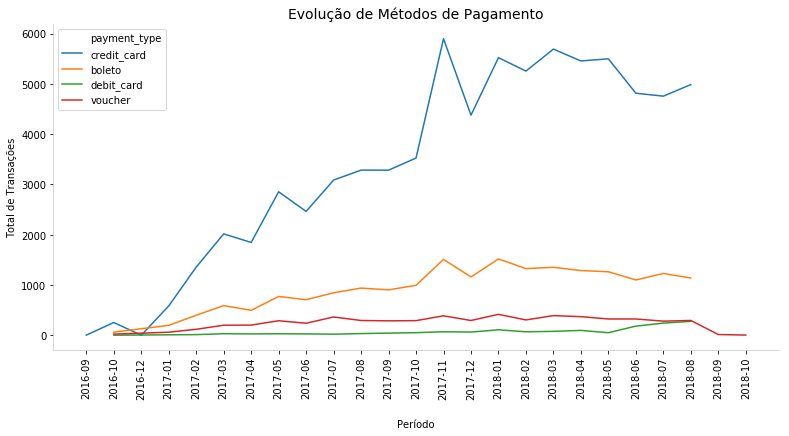

In [28]:
# Transformando coluna mês para correta ordenação na plotagem
payments_evolution['order_purchase_month'] = payments_evolution['order_purchase_month'].astype(str).\
apply(lambda x: '0' + x if len(x) == 1 else x)

# Criando nova coluna com ano-mês
payments_evolution['month_year'] = payments_evolution['order_purchase_year'].astype(str) + '-' + \
payments_evolution['order_purchase_month'].astype(str)

# Retornando o tipo primitivo da coluna mês
payments_evolution['order_purchase_month'] = payments_evolution['order_purchase_month'].astype(int)

# Plotando dados
fig, ax = plt.subplots(figsize=(13, 6))
ax = sns.lineplot(x='month_year', y='order_id', data=payments_evolution, hue='payment_type')
format_spines(ax, right_border=False)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('Período', labelpad=20)
ax.set_ylabel('Total de Transações')
ax.set_title('Evolução de Métodos de Pagamento', size=14)
plt.show()

### Categorias de Produtos

In [29]:
# Unindo datasets e preparando demais datasets para plotagem
df_order_products = df_orders_items.merge(olist_products, on='product_id', how='inner')

# Quantidade de vendas
df_qtd_product = df_order_products.groupby(['product_category_name'], 
                                             as_index=False).count()
df_qtd_product = df_qtd_product.loc[:, ['product_category_name', 'total_sales']]

# Receita total
df_sales_product = df_order_products.groupby(['product_category_name'], 
                                             as_index=False).sum()
df_sales_product = df_sales_product.loc[:, ['product_category_name', 'total_sales']]

# Valor médio por categoria
df_mean_product = df_order_products.groupby(['product_category_name'], 
                                             as_index=False).mean()
df_mean_product = df_mean_product.loc[:, ['product_category_name', 'total_sales']]

* **Quantidade de Vendas por Categoria**

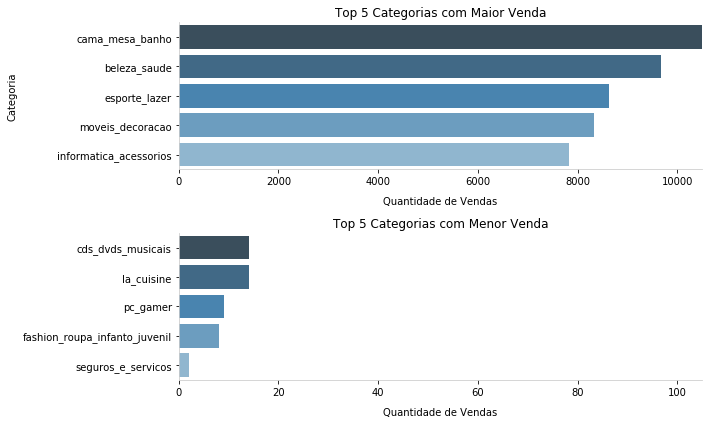

In [30]:
# Quantidade de Vendas
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
plot_param(df=df_qtd_product, col='total_sales', title='Top 5 Categorias com Maior Venda',
           xlim=10500, n_row=0, n_col=0, y='product_category_name', div_xlim=100,
           one_axis=True)
axs[1].set_xlabel('Quantidade de Vendas', labelpad=10)
axs[0].set_xlabel('Quantidade de Vendas', labelpad=10)
axs[0].set_ylabel('Categoria', labelpad=40)
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

* **Receita Gerada por Categoria**

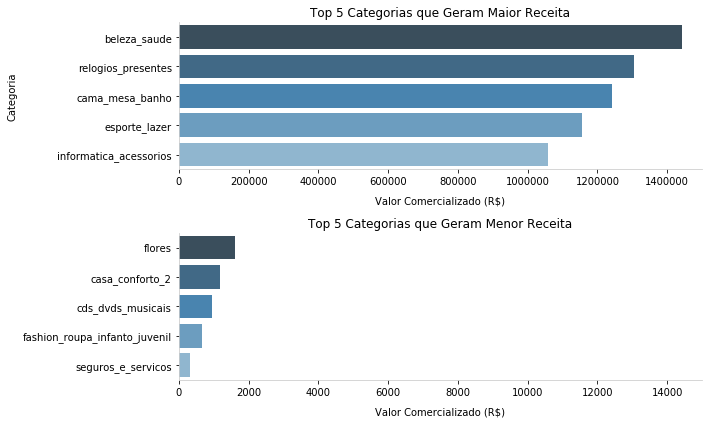

In [31]:
# Valor total de Vendas
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
plot_param(df=df_sales_product, col='total_sales', 
           title='Top 5 Categorias que Geram Maior Receita',
           xlim=1500000, n_row=0, n_col=0, y='product_category_name', div_xlim=100,
           one_axis=True)
axs[1].set_xlabel('Valor Comercializado (R$)', labelpad=10)
axs[0].set_xlabel('Valor Comercializado (R$)', labelpad=10)
axs[0].set_ylabel('Categoria', labelpad=40)
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

* **Valor Médio de Produtos por Categoria**

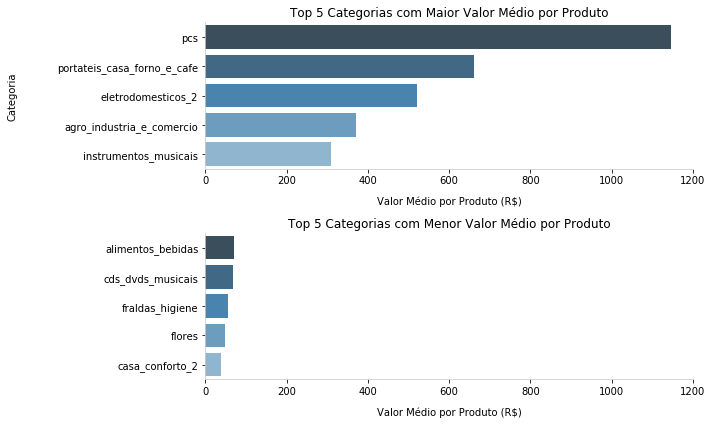

In [32]:
# Valor médio de produto por categoria
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
plot_param(df=df_mean_product, col='total_sales', 
           title='Top 5 Categorias com Maior Valor Médio por Produto',
           xlim=1200, n_row=0, n_col=0, y='product_category_name',
           one_axis=True)
axs[1].set_xlabel('Valor Médio por Produto (R$)', labelpad=10)
axs[0].set_xlabel('Valor Médio por Produto (R$)', labelpad=10)
axs[0].set_ylabel('Categoria', labelpad=40)
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()

### Review Score

* **Distribuição de Scores**

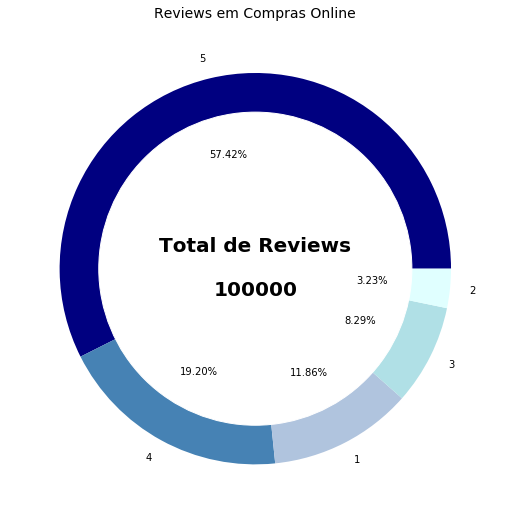

In [34]:
reviews_labels = olist_order_reviews['review_score'].value_counts().index
total_reviews = len(olist_order_reviews)
text = f'Total de Reviews\n\n{total_reviews}'
colors = ['navy', 'steelblue', 'lightsteelblue', 'powderblue', 'lightcyan']
fig, ax = plt.subplots(figsize=(9, 9))
donut_plot('review_score', ax, olist_order_reviews, labels=reviews_labels, text=text, colors=colors)
ax.set_title('Reviews em Compras Online', size=14)

plt.show()

# Processamento de Linguagem Natural

Após uma análise exploratória nos dados, realizada com o objetivo de propor uma familiarização e uma imersão no contexto do problema de negócio a ser resolvido, os próximos passos irão contemplar, de fato, a aplicação de técnicas de Processamento de Linguagem Natural de acordo com o objetivo proposto.

Entre os conjuntos de dados disponibilizados que descrevem fatos sobre o E-Commerce no Brasil, existem informações a respeito de _reviews_ (ou críticas) deixadas por compradores nas plataformas online. O objetivo deste projeto é analisar este dados e propor um algoritmo de classificação de sentimentos para captar como o consumidor se sente a medida que o fluxo de compras via e-commerce ocorre.

## Contato Inicial com o Dataset

Como citado, abaixo encontra-se um exemplo do dataset a ser utilizado.

In [35]:
# Dados com críticas de clientes
olist_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [37]:
# Dimensões
print(f'Este dataset possui {olist_order_reviews.shape[0]} linhas e {olist_order_reviews.shape[1]} colunas.')

Este dataset possui 100000 linhas e 7 colunas.


Informações disponíveis:

* **review_id:** chave primária que identifica a crítica;
* **order_id:** chave estrangeira para conectar ao dataset de pedidos;
* **review_score:** score dado pelo cliente para cada pedido;
* **review_comment_title:** título do comentário deixado pelo cliente;
* **review_comment_message:** comentário/crítica deixada pelo cliente;
* **review_creation_date:** data da criação do comentário;
* **review_answer_timestamp:** data da resposta dada

Já no cabeçalho dos dados, é possível visualizar dados nulos. 

In [36]:
# Dados nulos
olist_order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Os dados nulos presentes concentram-se nas colunas de título e de mensagem da crítica/comentário. É possível que exista uma relação entre ambos, como por exemplo, títulos não existentes estão relacionados a críticas não existentes e vice e versa. Para visualizar essa correlação entre dados nulos, será utilizada a biblioteca [_missigno_](https://github.com/ResidentMario/missingno).

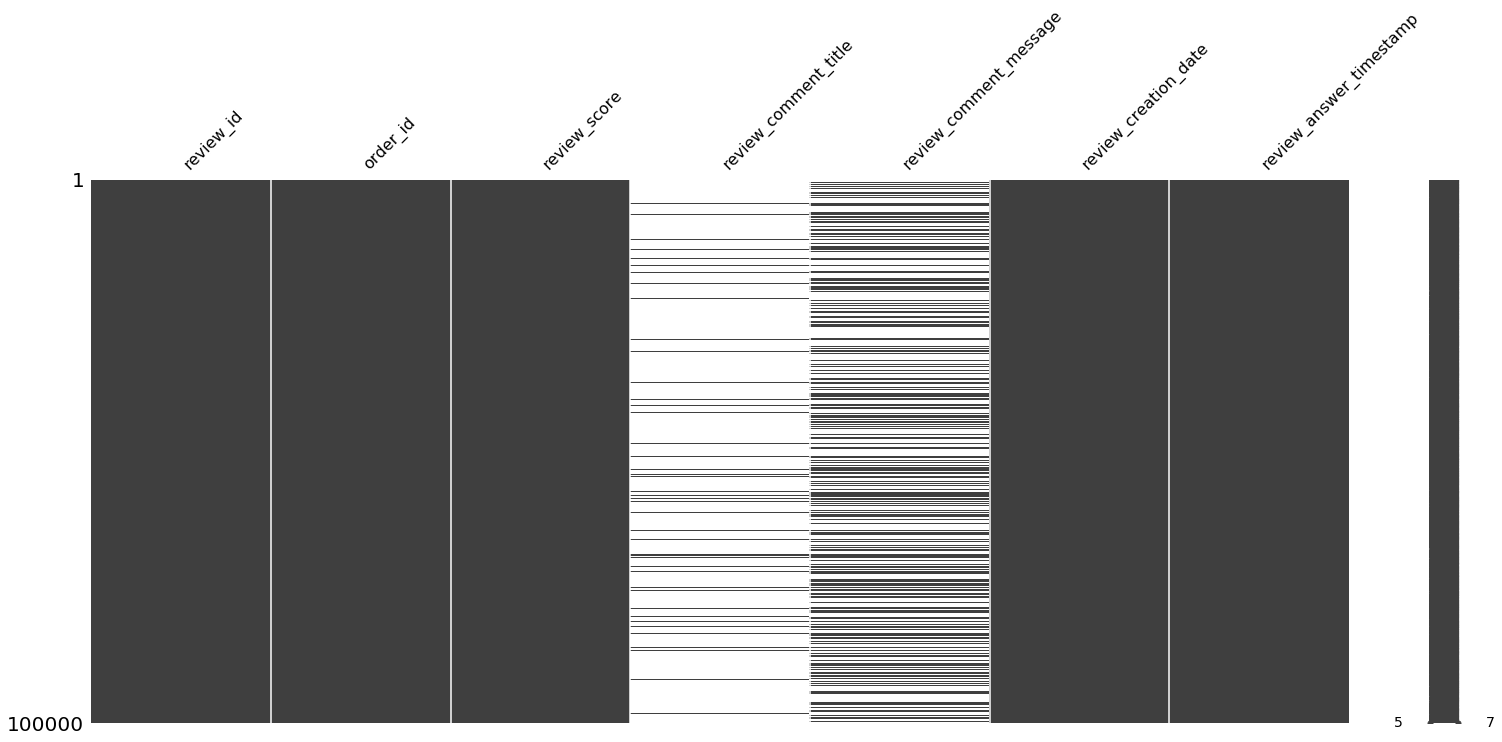

In [46]:
# Correlação entre estes dados nulos
msno.matrix(olist_order_reviews)
plt.show()

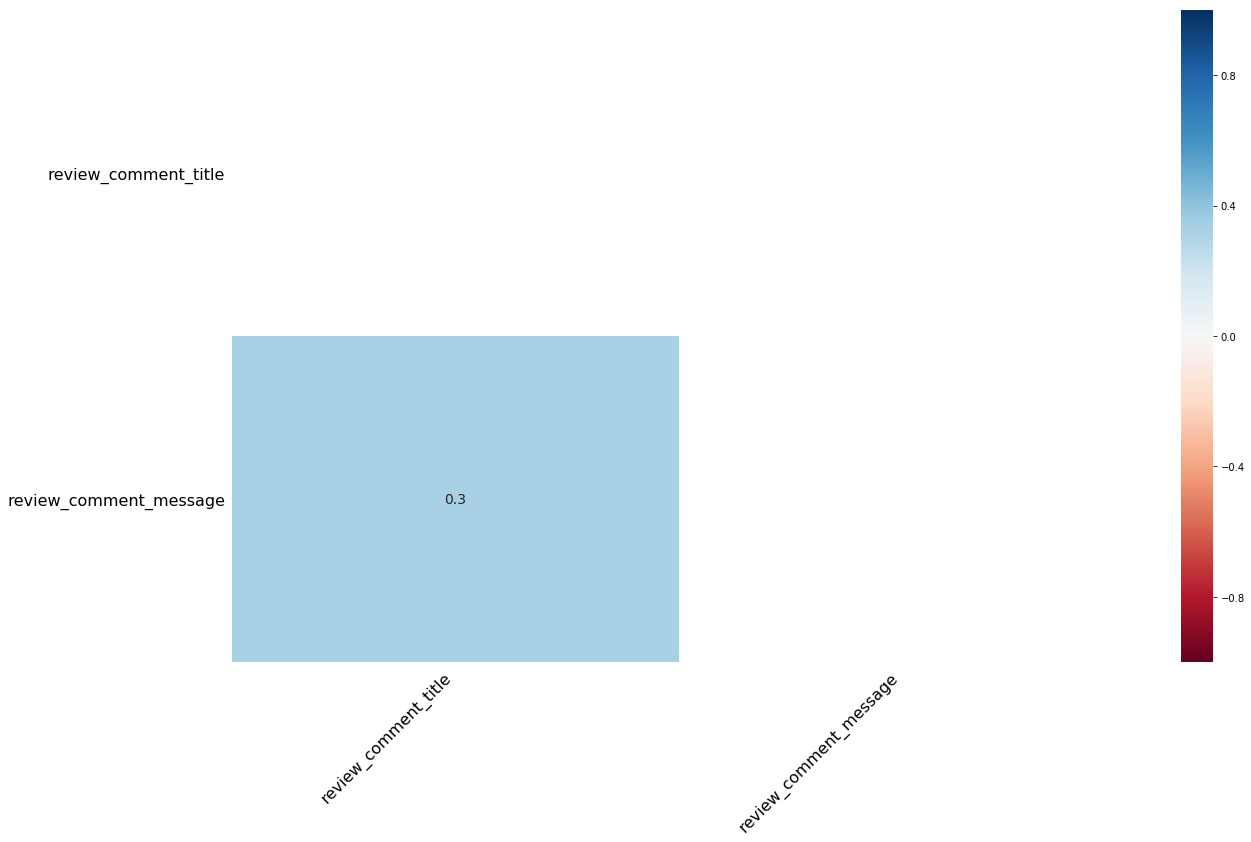

In [47]:
# Correlação entre dados nulos
msno.heatmap(olist_order_reviews)
plt.show()

Realmente a plotagem de correlação de dados nulos mostra que existe uma relação entre críticas nulas com títulos nulos. Levando em consideração os objetivos do projeto, será realizada a remoção de dados nulos da coluna *review_comment_message*.

In [52]:
# Removendo dados nulos
reviews = olist_order_reviews.dropna(subset=['review_comment_message'])
print(f'Restaram {reviews.shape[0]} críticas a serem analisada.')

Restaram 41753 críticas a serem analisada.


In [70]:
# Exemplos
for i in range(5):
    print(f'Crítica {i+1}: {np.random.choice(reviews["review_comment_message"])}')

Crítica 1: Produto muito bonito material muito bom, muito satisfeito com a compra...
Crítica 2: Entrega do produto com 15 dias de antecedência ao prazo informado. Parabéns!!! 
Crítica 3: Bonito, porem bem pequeno
Crítica 4: Excelente compra!
Crítica 5: O produto não foi recebido além de não ter recebido nenhuma notificação do vendedor sobre a não entrega.


Depois de analisar brevemente o conteúdo a ser trabalhado, é possível dar os primeiros passos para a construção de um modelo de análise de sentimentos. A seguir, será proposta uma análise utilizamos Expressões Regulares a fim de identificar se existem alguns elementos de HTML nas críticas fornecidas pelo dataset.

## RegEx

Pelo fato de se trabalhar com um conteúdo oriundo da internet, é possível que algumas tags HTML, ou mesmo tags de quebra de linha e outros padrões, estejam presentes nos comentários deste dataset. Em um primeiro momento, deve ser feita uma investigação pra confirmar essa hipótese a partir de algumas funcionalidades trazidas pelas Expressões Regulares.

In [92]:
# Verificando um exemplo de comentário
critica = reviews.iloc[3, 4]
critica

'Mas um pouco ,travando...pelo valor ta Boa.\r\n'

Aqui é possível visualizar as tags \r (_carriage return_ código ASCII 10) e \n (_new line_ código ASCII 13). Através de RegEx, é possível procurar este padrão dentro do texto.

In [93]:
# Aplicando expressão
p = re.compile(r'\n')
s = p.search(critica)
print(s)

<re.Match object; span=(44, 45), match='\n'>


O resultado acima mostra que o padrão "\n" foi encontrado nas posições indicadas por `span=(44, 45)`. Será mesmo?

In [94]:
# Confirmando
critica[44]

'\n'

Entretando, podem existir comentários com mais de uma quebra de linha ou outra expressão característica. Exemplo:

In [102]:
# Comentário com mais de uma tag
critica2 = reviews.iloc[48, 4]
critica2

'Estava faltando apenas um produto, eu recebi hoje , muito obrigada!\r\nTudo certo!\r\n\r\nAtt \r\n\r\nElenice.'

Em casos como este, rodar o _search_ da expressão regular criada irá retornar apenas a primeira aparição da expressão procurada.

In [105]:
# Testando
s = p.search(critica2)
print(s)

<re.Match object; span=(68, 69), match='\n'>


Para retornar todas as possíveis posições da expressão procurada, é preciso utilizar o método `finditer()`.

In [106]:
# Retornando todos os resultados
iterator = p.finditer(critica2)
for match in iterator:
    print(match.span())

(68, 69)
(81, 82)
(83, 84)
(89, 90)
(91, 92)


In [119]:
positions_dict = {}
i = 0
for c in list(criticas)[:10]:
    control_key = f'Crítica {i}'
    positions_dict[control_key] = list(criticas).index(c)
    i += 1

In [120]:
positions_dict

{'Crítica 0': 0,
 'Crítica 1': 1,
 'Crítica 2': 2,
 'Crítica 3': 3,
 'Crítica 4': 4,
 'Crítica 5': 5,
 'Crítica 6': 6,
 'Crítica 7': 7,
 'Crítica 8': 8,
 'Crítica 9': 9}

Fazer um for no iterator e dar append na chave na lista de posições

In [115]:
control_key

'Crítica 0'

In [110]:
# Testando em todo o dataset
positions_dict = {}
i = 0
control_key = f'Crítica {i}'
for c in list(criticas):
    iterator = p.finditer(c)
    for match in iterator:
        print(match.span())

(44, 45)
(35, 36)
(86, 87)
(138, 139)
(46, 47)
(71, 72)
(90, 91)
(67, 68)
(11, 12)
(61, 62)
(63, 64)
(18, 19)
(98, 99)
(128, 129)
(21, 22)
(68, 69)
(81, 82)
(83, 84)
(89, 90)
(91, 92)
(149, 150)
(61, 62)
(65, 66)
(118, 119)
(13, 14)
(10, 11)
(12, 13)
(145, 146)
(38, 39)
(23, 24)
(65, 66)
(32, 33)
(59, 60)
(76, 77)
(50, 51)
(39, 40)
(132, 133)
(6, 7)
(33, 34)
(92, 93)
(37, 38)
(39, 40)
(44, 45)
(33, 34)
(69, 70)
(46, 47)
(36, 37)
(70, 71)
(114, 115)
(51, 52)
(71, 72)
(21, 22)
(41, 42)
(61, 62)
(68, 69)
(56, 57)
(59, 60)
(85, 86)
(89, 90)
(124, 125)
(13, 14)
(58, 59)
(82, 83)
(63, 64)
(74, 75)
(135, 136)
(39, 40)
(68, 69)
(27, 28)
(62, 63)
(44, 45)
(10, 11)
(43, 44)
(36, 37)
(95, 96)
(97, 98)
(41, 42)
(137, 138)
(78, 79)
(113, 114)
(70, 71)
(38, 39)
(148, 149)
(60, 61)
(103, 104)
(80, 81)
(82, 83)
(12, 13)
(49, 50)
(78, 79)
(94, 95)
(116, 117)
(86, 87)
(97, 98)
(121, 122)
(69, 70)
(85, 86)
(87, 88)
(119, 120)
(17, 18)
(43, 44)
(36, 37)
(32, 33)
(51, 52)
(12, 13)
(25, 26)
(29, 30)
(119, 1

(68, 69)
(67, 68)
(134, 135)
(39, 40)
(38, 39)
(93, 94)
(123, 124)
(21, 22)
(76, 77)
(117, 118)
(156, 157)
(32, 33)
(49, 50)
(21, 22)
(18, 19)
(37, 38)
(91, 92)
(107, 108)
(74, 75)
(21, 22)
(44, 45)
(91, 92)
(61, 62)
(63, 64)
(110, 111)
(35, 36)
(42, 43)
(94, 95)
(39, 40)
(41, 42)
(37, 38)
(102, 103)
(104, 105)
(106, 107)
(73, 74)
(123, 124)
(155, 156)
(157, 158)
(12, 13)
(181, 182)
(48, 49)
(32, 33)
(4, 5)
(9, 10)
(11, 12)
(70, 71)
(82, 83)
(90, 91)
(47, 48)
(49, 50)
(72, 73)
(151, 152)
(126, 127)
(42, 43)
(118, 119)
(72, 73)
(4, 5)
(6, 7)
(29, 30)
(33, 34)
(78, 79)
(124, 125)
(164, 165)
(170, 171)
(46, 47)
(67, 68)
(43, 44)
(61, 62)
(45, 46)
(119, 120)
(34, 35)
(84, 85)
(37, 38)
(62, 63)
(80, 81)
(52, 53)
(85, 86)
(135, 136)
(90, 91)
(92, 93)
(82, 83)
(84, 85)
(105, 106)
(141, 142)
(179, 180)
(181, 182)
(44, 45)
(26, 27)
(53, 54)
(61, 62)
(82, 83)
(49, 50)
(38, 39)
(70, 71)
(81, 82)
(41, 42)
(43, 44)
(34, 35)
(1, 2)
(3, 4)
(5, 6)
(144, 145)
(98, 99)
(13, 14)
(69, 70)
(18, 19)
(39, 40

(127, 128)
(23, 24)
(45, 46)
(47, 48)
(51, 52)
(53, 54)
(91, 92)
(132, 133)
(41, 42)
(68, 69)
(47, 48)
(93, 94)
(37, 38)
(93, 94)
(40, 41)
(52, 53)
(74, 75)
(71, 72)
(132, 133)
(53, 54)
(55, 56)
(110, 111)
(112, 113)
(18, 19)
(17, 18)
(95, 96)
(55, 56)
(46, 47)
(48, 49)
(65, 66)
(9, 10)
(63, 64)
(92, 93)
(55, 56)
(110, 111)
(10, 11)
(12, 13)
(48, 49)
(96, 97)
(146, 147)
(39, 40)
(51, 52)
(100, 101)
(125, 126)
(160, 161)
(191, 192)
(28, 29)
(94, 95)
(12, 13)
(79, 80)
(81, 82)
(105, 106)
(107, 108)
(16, 17)
(18, 19)
(76, 77)
(108, 109)
(125, 126)
(14, 15)
(9, 10)
(161, 162)
